In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import xarray as xr
import pandas as pd
import xcorr

In [3]:
plt.rcParams.update({'font.size': 9})

In [4]:
root = '../datasets'

In [5]:
snr_ct = xr.open_dataset(f'{root}/snr_ct__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2014121__2020366.nc')
plane_wave = xr.open_dataset(f'{root}/beamform__IM.H03S[1-3]..EDH-IU.RAR.10.BHZ__2014121__2020366.nc')

In [6]:
snr_ct

<xarray.Dataset>
Dimensions:    (pair: 6, time: 19385)
Coordinates:
  * pair       (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHR' ... 'IM.H03S3..EDH...
  * time       (time) datetime64[ns] 2014-05-01 ... 2020-12-31T21:00:00
Data variables:
    ct         (time) float64 ...
    lag_s_max  (pair, time) float64 ...
    n          (pair, time) float32 ...
    s          (pair, time) float32 ...
    snr        (pair, time) float32 ...
Attributes: (12/14)
    title:                 Monowai Volcanic Centre: signal-to-noise ratio 201...
    institution:           Delft University of Technology, Department of Geos...
    author:                Pieter Smets - P.S.M.Smets@tudelft.nl
    source:                CTBTO/IMS hydroacoustic data and IRIS/USGS seismic...
    references:            Smets, Weemstra and Evers (2022). Hydroacoustic tr...
    comment:               n/a
    ...                    ...
    xcorr_version:         0.7.0
    dependencies_version:  json-2.0.9, numpy-1.21.4, obspy-1.2.2, pandas-1.3....
    sha256_hash_metadata:  d316308c2f108cf96b3b5908093008479d8d2041de9cbcc1a4...
    sha256_hash:           98d6ecff0d558bfb5bf5f55fc37a4041c6caaf1292bc1cf0fd...
    doi:                    https://doi.org/10.5281/zenodo.5891059
    format:                netCDF-4

In [7]:
plane_wave

<xarray.Dataset>
Dimensions:  (pair: 3, time: 19264)
Coordinates:
  * pair     (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHZ' ... 'IM.H03S3..EDH-I...
  * time     (time) datetime64[ns] 2014-05-01 ... 2020-12-31T21:00:00
Data variables:
    doa      (time) float64 ...
    err      (time) float64 ...
    s_x      (time) float64 ...
    s_y      (time) float64 ...
    vel      (time) float64 ...
    x        (pair, time) float64 ...
    y        (pair, time) float64 ...
Attributes:
    sha256_hash_metadata:  56d2be523e6420645ba70a1f13bd15f9cb963b04f6d010e5b9...
    sha256_hash:           81e3165171ef734095034ed5f196f0fe384e51f71eb37c7b1a...
    title:                 Monowai Volcanic Centre: least-squares estimated p...
    doi:                    https://doi.org/10.5281/zenodo.5891059
    references:            Smets, Weemstra and Evers (2022). Hydroacoustic tr...
    xcorr_version:         0.7.0
    format:                netCDF-4
    envelope:              0

In [8]:
plane_wave_mvc = ((plane_wave.doa >= 241) & (plane_wave.doa <= 243) &
                  (plane_wave.vel >= 1490) & (plane_wave.vel <= 1495) &
                  (plane_wave.err < 0.02))
    
selected_times = plane_wave.time.where(plane_wave_mvc & (snr_ct.ct >= 0), drop=True)
bad_times = plane_wave.time.where(~plane_wave_mvc & (snr_ct.ct >= 0), drop=True)

Group per year

In [9]:
snr_ct_per_year = snr_ct.groupby(snr_ct.time.dt.year)
snr_ct_per_year

DatasetGroupBy, grouped over 'year' 
7 groups with labels 2014, 2015, 2016, ..., 2019, 2020.

In [10]:
def set_year_labels(ax, start='2014-01-01', end='2021-01-01', ticklabels=True, **kwargs):
    """Add yearly x-axis time labels (centered)
    """
    t0, t1 = pd.to_datetime(start), pd.to_datetime(end)

    ax.set_xlim(t0.to_datetime64(), t1.to_datetime64())
    ax.set_xlabel(None)

    ticks = pd.date_range(t0, t1, freq='1YS')
    labels = pd.date_range(t0 + pd.DateOffset(month=7),
                           t1 + pd.DateOffset(month=7),
                           freq='12M')

    ax.set_xticks(ticks.values)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())

    ax.set_xticks(labels.values, minor=True)
    if ticklabels:
        ax.set_xticklabels(labels.strftime("%Y").values, minor=True, **kwargs)

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')


def set_month_labels(ax, year, ticklabels=True, **kwargs):
    """Add monthly x-axis time labels (centered)
    """
    t0, t1 = pd.to_datetime(f'{year}-01-01'), pd.to_datetime(f'{year+1}-01-01')

    ax.set_xlim(t0.to_datetime64(), t1.to_datetime64())
    ax.set_xlabel(None)

    ticks = pd.date_range(t0, t1, freq='1MS')
    labels = ticks[:-1] + pd.DateOffset(days=14)

    ax.set_xticks(ticks.values)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())

    ax.set_xticks(labels.values, minor=True)

    if ticklabels:
        ax.set_xticklabels(labels.strftime("%b").values, minor=True, **kwargs)

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

## Figure 6: non-robust time lag over time (at peak envelope)

Plot total period

<IPython.core.display.Javascript object>


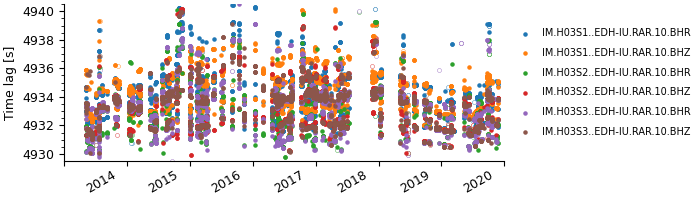

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(7, 2))

gs = GridSpec(1, 2, figure=fig, width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

snr_ct.lag_s_max.sel(time=bad_times).sortby('time', ascending=False).plot.line(
    x='time', ax=ax1, add_legend=False,
    mfc='white', marker='o', linewidth=0, markersize=2.9, mew=.3,
    zorder=-1,
)
snr_ct.sel(time=selected_times).plot.scatter(
    x='time', y='lag_s_max', hue='pair', s=5,
    ax=ax1, add_guide=False
)
legend = ax1.get_legend_handles_labels()

ax1.set_ylabel('Time lag [s]')
ax1.set_ylim(4929.5, 4940.5)
set_year_labels(ax1, rotation=30)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax2.set_frame_on(False)
ax2.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax2.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=1, borderpad=-1)

plt.savefig('figs/H03S_lag_time.pdf', bbox_inches='tight')

Plot total period and zoom-in

<IPython.core.display.Javascript object>


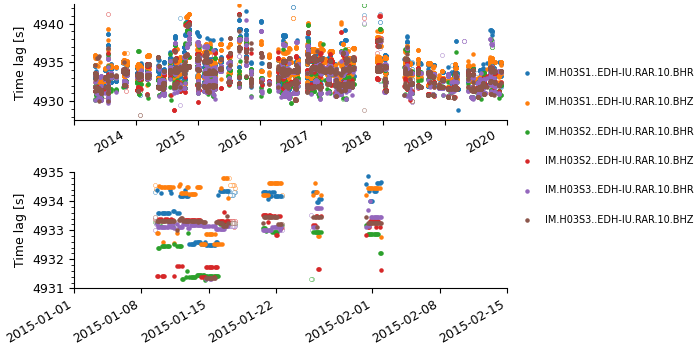

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3.5))

gs = GridSpec(2, 2, figure=fig, height_ratios=(1, 1), width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

snr_ct.lag_s_max.sel(time=bad_times).sortby('time', ascending=False).plot.line(
    x='time', ax=ax1, add_legend=False,
    mfc='white', marker='o', linewidth=0, markersize=2.9, mew=.3,
    zorder=-1,
)
snr_ct.sel(time=selected_times).plot.scatter(
    x='time', y='lag_s_max', hue='pair', s=5,
    ax=ax1, add_guide=False
)
legend = ax1.get_legend_handles_labels()

ax1.set_ylabel('Time lag [s]')
ax1.set_ylim(4927.5, 4942.5)
set_year_labels(ax1, rotation=30)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

snr_ct.lag_s_max.sel(time=bad_times).sortby('time', ascending=False).plot.line(
    x='time', ax=ax2, add_legend=False,
    mfc='white', marker='o', linewidth=0, markersize=2.9, mew=.3,
    zorder=-1,
)
snr_ct.sel(time=selected_times).plot.scatter(
    x='time', y='lag_s_max', hue='pair', s=5,
    ax=ax2, add_guide=False
)
ax2.set_ylabel('Time lag [s]')
ax2.set_xlim(np.datetime64('2015-01-01'), np.datetime64('2015-02-15'))
ax2.set_ylim(4931, 4935)
ax2.set_xlabel(None)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(axis='x', rotation=30)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

ax3.set_frame_on(False)
ax3.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax3.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=-1)

plt.savefig('figs/H03S_lag_time_zoom.pdf', bbox_inches='tight')

Plot separate years

<IPython.core.display.Javascript object>


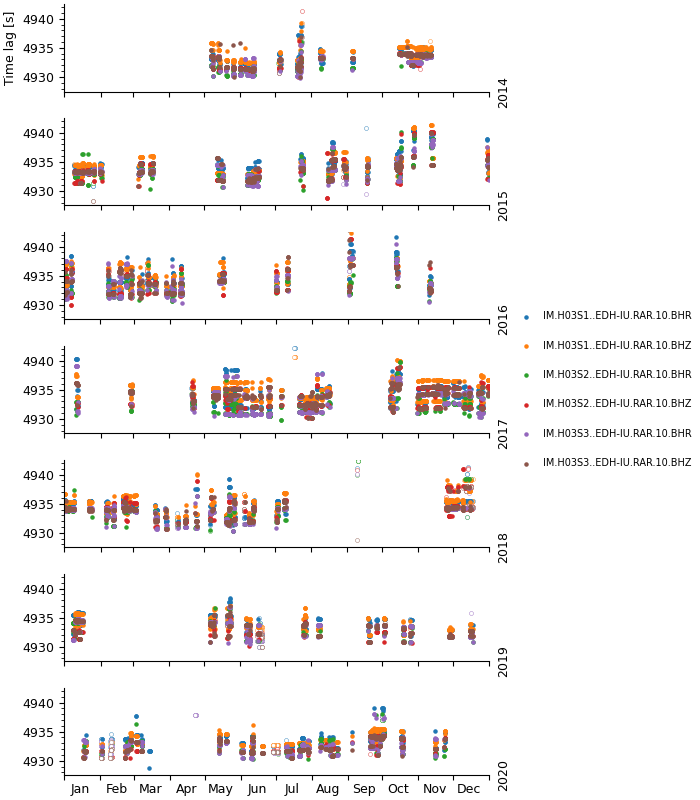

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(7, len(snr_ct_per_year) + 1))

gs = GridSpec(len(snr_ct_per_year), 2, figure=fig, width_ratios=(2.5, 1))
axis = []

for i, group in enumerate(snr_ct_per_year):
    year, snr_ct_year = group

    ax = fig.add_subplot(gs[i, 0])
    
    (snr_ct_year.lag_s_max
        .sel(time=bad_times.where(bad_times.dt.year == year, drop=True))
        .sortby('time', ascending=False)
        .plot.line(
            x='time', ax=ax, add_legend=False,
            mfc='white', marker='o', linewidth=0, markersize=2.9, mew=.3,
            zorder=-1,
        )
    )
    (snr_ct_year
        .sel(time=selected_times.where(selected_times.dt.year == year, drop=True))
        .plot.scatter(
            x='time', y='lag_s_max', hue='pair', s=5,
            ax=ax, add_guide=False
        )
    )
    
    show_xlabel = i == (len(snr_ct_per_year)-1)
    set_month_labels(ax, year, ticklabels=show_xlabel, rotation=0)
    ax.set_title(None)
    ax.set_ylabel('Time lag [s]' if i == 0 else None)
    ax.set_ylim(4927.5, 4942.5)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.text(1.02, 0, str(year), transform=ax.transAxes, ha='left', va='center', rotation=90)

    axis.append(ax)
    
legend = axis[0].get_legend_handles_labels()

ax = fig.add_subplot(gs[:, 1])
ax.set_frame_on(False)
ax.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=-1.5)

plt.show()
plt.savefig('figs/H03S_lag_time_per_year.pdf', bbox_inches='tight')

## Figure 4: S/N with triggers

Plot total period and zoom-in

<IPython.core.display.Javascript object>


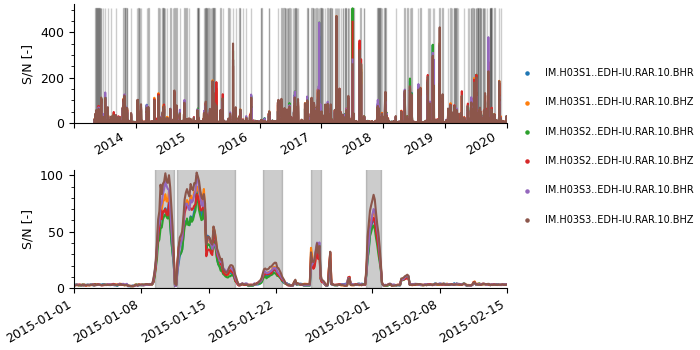

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3.5))

gs = GridSpec(2, 2, figure=fig, height_ratios=(1, 1), width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

snr_ct.snr.plot.line(x='time', hue='pair', ax=ax1, add_legend=False)
xcorr.signal.trigger.plot_trigs(snr_ct.snr, snr_ct.ct, ax=ax1)
set_year_labels(ax1, rotation=30)
ax1.set_ylim(0, 525)
ax1.set_ylabel('S/N [-]')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

snr_ct.snr.plot.line(x='time', hue='pair', ax=ax2, add_legend=False)
#legend = ax1.get_legend_handles_labels()
xcorr.signal.trigger.plot_trigs(snr_ct.snr, snr_ct.ct, ax=ax2)
ax2.set_xlim(np.datetime64('2015-01-01'), np.datetime64('2015-02-15'))
ax2.set_ylim(0, 105)
ax2.set_ylabel('S/N [-]')
ax2.set_xlabel(None)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(axis='x', rotation=30)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

ax3.set_frame_on(False)
ax3.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax3.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=-1)

plt.savefig('figs/H03S_SN.pdf', bbox_inches='tight')

Plot as separate years

<IPython.core.display.Javascript object>


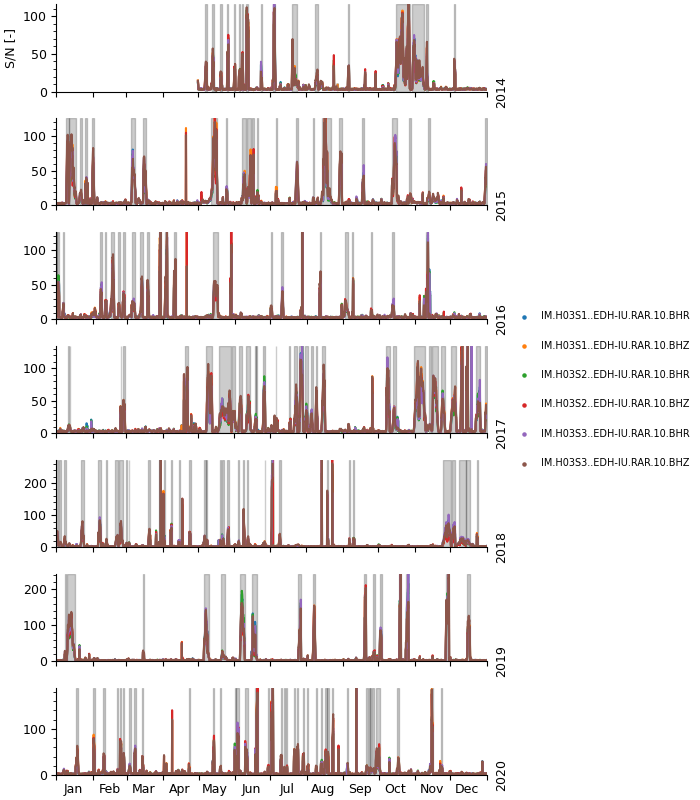

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(7, len(snr_ct_per_year) + 1))

gs = GridSpec(len(snr_ct_per_year), 2, figure=fig, width_ratios=(2.5, 1))
axis = []

for i, group in enumerate(snr_ct_per_year):
    year, snr_ct_year = group

    ax = fig.add_subplot(gs[i, 0])
    
    ylim = (0, snr_ct_year.snr.quantile(.999))

    snr_ct_year.snr.plot.line(x='time', hue='pair', ax=ax, add_legend=False)
    xcorr.signal.trigger.plot_trigs(snr_ct_year.snr, snr_ct_year.ct, ax=ax, ylim=ylim)

    show_labels = i == (len(snr_ct_per_year)-1)
    set_month_labels(ax, year, ticklabels=show_labels, rotation=0)
    ax.set_title(None)
    ax.set_ylabel('S/N [-]' if i == 0 else None)
    ax.set_ylim(ylim)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.text(1.02, 0, str(year), transform=ax.transAxes, ha='left', va='center', rotation=90)

    axis.append(ax)

ax = fig.add_subplot(gs[:, 1])
ax.set_frame_on(False)
ax.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=-1.5)

plt.show()
plt.savefig('figs/H03S_SN_per_year.pdf', bbox_inches='tight')

## Figure 5: source activity insight

Active periods

In [16]:
ct_per = xcorr.signal.trigger.trigger_periods(snr_ct.ct)

Boxplot settings

In [17]:
boxplot_args = dict(
    subplots=False,
    grid=False,
    notch=False,
    meanline=True,
    showmeans=True,
    whiskerprops=dict(color='k'),
    boxprops=dict(color='black', linewidth=1),
    medianprops=dict(linestyle='-', linewidth=1, color='k'),
    meanprops=dict(linestyle=':', linewidth=1, color='k'),
    flierprops=dict(marker='o', markeredgecolor='k', markerfacecolor='None',
                      markersize=4, linestyle='none'),
)

Activity grouped per year

In [18]:
grouped_y = ct_per[ct_per.days >= 1].groupby(ct_per.start.dt.to_period("Y"))

df_y = grouped_y.sum()
df_y['median'] = grouped_y.median()
df_y['mean'] = grouped_y.mean()
df_y['std'] = grouped_y.std()
df_y['periods'] = grouped_y['days'].count()

df_y.index = df_y.index.rename('year')

Activity grouped per month

In [19]:
grouped_m = ct_per[ct_per.days >= 1].groupby(ct_per.start.dt.month)

df_m = grouped_m.sum()
df_m['median'] = grouped_m.median()
df_m['mean'] = grouped_m.mean()
df_m['std'] = grouped_m.std()
df_m['periods'] = grouped_m['days'].count()

df_m.index = df_m.index.rename('month')

Plot activity per year and per month

<IPython.core.display.Javascript object>


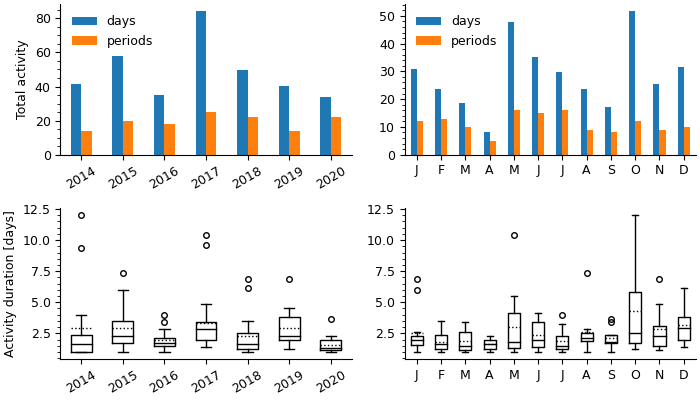

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(7, 4))

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

df_y[['days', 'periods']].plot.bar(rot=30, ax=ax1)
ax1.set_ylabel('Total activity')
ax1.set_xlabel(None)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.legend(frameon=False, loc='upper left')

grouped_y.boxplot(rot=30, ax=ax2,  **boxplot_args)
ax2.set_ylabel('Activity duration [days]')
ax2.set_xticklabels([str(v) for v in df_y.index.values])
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

df_m[['days', 'periods']].plot.bar(rot=0, ax=ax3)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_xticklabels([str(v)[0] for v in pd.to_datetime(df_m.index, format='%m').month_name()])
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.legend(frameon=False, loc='upper left')

grouped_m.boxplot(rot=0, ax=ax4, **boxplot_args)
ax4.set_ylabel(None)
ax4.set_xticklabels([str(v)[0] for v in pd.to_datetime(df_m.index, format='%m').month_name()])
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.savefig('figs/H03S_activity.pdf', bbox_inches='tight')